In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import TensorDataset, TensorDataset
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

# Definisi Class Encoder, Decoder, dan Deep SMOTE

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()#args=>channel=3

        self.channel_img = 3 # rgb
        self.hidden_size = 64 # neuron
        self.flatten_size = 100 # feature extraction

        self.conv = nn.Sequential(
            nn.Conv2d(self.channel_img, self.hidden_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size, self.hidden_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size * 2, self.hidden_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size * 4, self.hidden_size * 8, 4, 2, 1, bias=False),

            nn.BatchNorm2d(self.hidden_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc = nn.Linear(self.hidden_size * (2**3) *14*14, self.flatten_size)

    def forward(self, x):
        x = self.conv(x).reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        #setting arguments
        self.channel_img = 3
        self.hidden_size = 64
        self.flatten_size = 100

        #layers decoder
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, self.hidden_size * 8 * 14 * 14),
            nn.ReLU(inplace=True)
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.hidden_size * 8, self.hidden_size * 4, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size * 4, self.hidden_size *2, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size * 2, self.hidden_size, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size, self.channel_img, 4,2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x).reshape(x.size(0), self.hidden_size * 8, 14, 14)
        x = self.deconv(x)
        return x

In [ ]:
class DeepSMOTE:
    def __init__(self, encoder, decoder):
        self.encoder    = encoder
        self.decoder    = decoder
        self.criterion  = nn.MSELoss()
        self.perform = {'train_loss':[], 'rec_loss':[], 'penalty_loss':[]}

    def compile(self, lr):
        self.enc_optimizer = torch.optim.Adam(self.encoder.parameters(), lr=lr)
        self.dec_optimizer = torch.optim.Adam(self.decoder.parameters(), lr=lr)

    def fit(self, X, device, epochs):
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        self.criterion = self.criterion.to(device)

        self.data_x = X['images'].permute(0,3,1,2)/255.0
        self.data_y = X['class']

        self.classes = torch.unique(X['class']).numpy()

        self.dataTensor = TensorDataset(self.data_x, self.data_y)
        self.train_loader = DataLoader(self.dataTensor, batch_size = 100, shuffle=True, num_workers = 0)
        self.compile(lr=0.001)
        time_start = time.time()
        best_loss = 99

        #training with epoch
        for epoch in range(epochs):
            train_loss      = 0
            rec_loss        = 0
            penalty_loss    = 0
            self.encoder.train()
            self.decoder.train()

            # batching on train_loader
            for images, labels in self.train_loader:
                # Stop when current batch' size is less than train_loader' batch size
                if images.shape[0] < 100:
                    break
                self.encoder.zero_grad()
                self.decoder.zero_grad()

                images = images.to(device)

                #encode-decode every batch
                mse = self.criterion(self.decoder(self.encoder(images)), images)

                #select class dan pengacakan class (CD)
                class_cd = np.random.choice(self.classes)
                x_cd = images[labels == class_cd]
                y_cd = labels[labels == class_cd]

                size_x = len(x_cd)
                i_shuffle = np.random.choice(list(range(size_x)), size_x, replace = False )
                xclass_cd = images[i_shuffle]
                yclass_cd = labels[i_shuffle]

                #Pengacakan anggota class CD menjadi cb
                size_cd = len(xclass_cd)
                j_shuffle = np.random.choice(list(range(size_cd)), size_cd, replace = False)
                xclass_cb = xclass_cd[j_shuffle]

                #encode xclass cd
                xclass_cd = xclass_cd.to(device)
                xclass_es = self.encoder(xclass_cd).detach()

                #permute encode cd #menggunakan pengacakan cb, indeksnya akan dicocokan dengan CD sebelum diekstrak
                xclass_pe = xclass_es[j_shuffle]

                #decode dp
                xclass_pe = xclass_pe.to(device)
                xclass_dp = self.decoder(xclass_pe)

                #penalty loss
                mse2 = self.criterion(xclass_dp, xclass_cb)

                combo_loss = mse + mse2
                combo_loss.backward()

                self.enc_optimizer.step()
                self.dec_optimizer.step()

                train_loss += combo_loss.item()
                rec_loss += mse.item()
                penalty_loss += mse2.item()

            #hitung training loss setiap epoch berdasarkan jumlah train loader
            train_loss = train_loss / len(self.train_loader)
            rec_loss = rec_loss / len(self.train_loader)
            penalty_loss = penalty_loss / len(self.train_loader)
            # 'train_loss':[], 'rec_loss':[], 'penalty_loss':[]}

            self.perform['train_loss'].append(train_loss)
            self.perform['rec_loss'].append(rec_loss)
            self.perform['penalty_loss'].append(penalty_loss)
            print(f"Epoch :{epoch+1} Train Loss: {train_loss} Rec Loss: {rec_loss} Penalty_loss: {penalty_loss}")

            if train_loss < best_loss:
                print("Menyimpan Model ....")
                torch.save(self.encoder.state_dict(), "best_encode.pth")
                torch.save(self.decoder.state_dict(), "best_decode.pth")

                best_loss = train_loss

                time_stop = time.time()
                self.timer = (time_stop - time_start)/60

        with open('model_perform.pkl', 'wb') as file:
            # A new file will be created
            pickle.dump(self.perform, file)

    def generate_samples(
            self,
            limit,
            target,
            device,
            path_encoder = "best_encode.pth",
            path_decoder = "best_decode.pth",
            show_sample = True
        ):

        self.gen_timer = time.time()
        self.encoder.load_state_dict(torch.load(path_encoder, map_location=device), strict=False)
        self.decoder.load_state_dict(torch.load(path_decoder, map_location=device), strict=False)

        self.encoder.to(device)
        self.decoder.to(device)

        self.encoder.eval()
        self.decoder.eval()

        gen_x = []
        gen_y = []
        for cls in self.classes:

            # process data
            x_class = self.data_x[self.data_y == cls]
            y_class = self.data_y[self.data_y == cls]

            x_class_l = x_class[:limit]
            y_class_l = y_class[:limit]

            x_class_l = x_class_l.to(device)

            #encodering
            x_class_l = self.encoder(x_class_l).detach().cpu()

            # ==== START SMOTE ====
            n_generate = target - len(y_class)
            #knn training for nearest neighbor
            kNN = NearestNeighbors(n_neighbors=5, n_jobs=1)
            kNN.fit(x_class_l)
            dist, ind = kNN.kneighbors(x_class_l)

            #generatting random index
            base = np.random.choice(list(range(len(x_class_l))), n_generate)

            NNindex = np.random.choice(list(range(5)), n_generate)

            X_base = x_class_l[base]
            X_nn = x_class_l[ind[base, NNindex]]

            #generate
            generate_sample = X_base + torch.mul(torch.from_numpy(np.random.rand(n_generate,1)),
                                                X_nn - X_base)

            x_sample, y_sample = generate_sample, torch.tensor([cls]*n_generate) #output torch dtype
            # ==== END SMOTE ====
            x_sample = x_sample.float().to(device)

            #decodering
            x_decode = self.decoder(x_sample).detach().cpu()
            x_decode = x_decode.permute(0,2,3,1)*255.0

            # TEMPORARY CODE : save plot comparison between image base, neighbor and generated using matplotlib
            # for i in range(n_generate):
            # save plot (x_class_l[base], x_class_l[ind[base,NNindex]]), x_decode
            if show_sample:
                if base.shape[0] == 0: # If there is no image that generated (current class is dominant)
                    continue
                fig, axs = plt.subplots(ncols=3, figsize=(7, 3))
                fig.suptitle('Sample Images')

                axs[0].imshow(x_class[base[0]].permute(1, 2, 0))
                axs[0].set_title('base image')
                axs[0].set_axis_off()

                axs[1].imshow(x_class[ind[base, NNindex][0]].permute(1, 2, 0))
                axs[1].set_title('neighbor image')
                axs[1].set_axis_off()

                axs[2].imshow(x_decode[0] / 255)
                axs[2].set_title('generated image')
                axs[2].set_axis_off()

                plt.show

            #saving
            gen_x.append(x_decode.to(dtype=torch.float16))
            gen_y.append(y_sample)

        # combine result torch all of class in one tensor

        self.gen_timer = time.time()-self.gen_timer
        print(self.gen_timer/60)
        return {'images': gen_x, 'class': gen_y}

In [ ]:
def load_data(path):

    images = []
    labels = []

    print("Loading {}".format(path))

    # Iterate through each folder corresponding to a category
    for i, folder in enumerate(os.listdir(path)):
        label = i
        for file in tqdm(os.listdir(os.path.join(path, folder))):

            # Get the path name of the image
            img_path = os.path.join(os.path.join(path, folder), file)

            # Open and resize the img
            image = cv2.imread(img_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = np.uint8)
    labels = np.array(labels, dtype = np.uint8)

    return (images, labels)

# Deep SMOTE data training tanpa CLAHE

## Load data training

In [ ]:
images, labels = load_data(path="/content/drive/MyDrive/SKRIPSI/dataset/original/train")

Loading /content/drive/MyDrive/SKRIPSI/dataset/original/train


100%|██████████| 643/643 [00:17<00:00, 36.15it/s] 


## Training model

In [ ]:
deepsmote = DeepSMOTE(Encoder(), Decoder())

In [ ]:
deepsmote.fit(
    X={
        'images': torch.tensor(images, dtype=torch.uint8),
        'class': torch.tensor(labels, dtype=torch.uint8)
    },
    epochs=100,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Epoch :1 Train Loss: 0.4783022784524494 Rec Loss: 0.23878331427220945 Penalty_loss: 0.23951896169671305
Menyimpan Model ....
Epoch :2 Train Loss: 0.1597452715591148 Rec Loss: 0.0780639546336951 Penalty_loss: 0.08168131664947227
Menyimpan Model ....
Epoch :3 Train Loss: 0.1245179686833311 Rec Loss: 0.06110971007082197 Penalty_loss: 0.06340825888845655
Menyimpan Model ....
Epoch :4 Train Loss: 0.10864466677109401 Rec Loss: 0.054008051891017844 Penalty_loss: 0.05463661488007616
Menyimpan Model ....
Epoch :5 Train Loss: 0.10136298476545899 Rec Loss: 0.04981681925279123 Penalty_loss: 0.05154616551266776
Menyimpan Model ....
Epoch :6 Train Loss: 0.09015951195248852 Rec Loss: 0.0438394041524993 Penalty_loss: 0.04632010738606806
Menyimpan Model ....
Epoch :7 Train Loss: 0.08465330689041703 Rec Loss: 0.04182057358600475 Penalty_loss: 0.04283273316643856
Menyimpan Model ....
Epoch :8 Train Loss: 0.08352907664246029 Rec Loss: 0.04113772842619154 Penalty_loss: 0.04239134766437389
Menyimpan Model .

## Menampilkan nilai loss setiap epoch

In [ ]:
def plot_history(history):
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['rec_loss'], label='Rec Loss')
    plt.plot(history['penalty_loss'], label='Penalty Loss')

    # Menambahkan label dan judul plot
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss, Rec Loss, dan Penalty Loss')

    # Menampilkan legenda
    plt.legend()

    # Menampilkan plot
    plt.show()

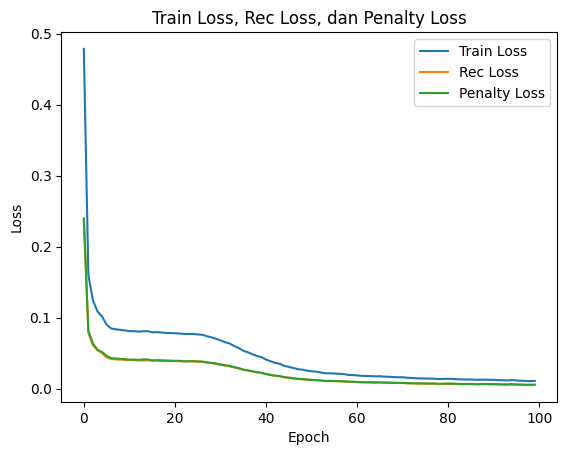

In [ ]:
plot_history(deepsmote.perform)

In [ ]:
!mkdir -p "/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/original"
!cp best_decode.pth "/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/original/best_decode.pth"
!cp best_encode.pth "/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/original/best_encode.pth"
!cp model_perform.pkl "/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/original/model_perform.pkl"

## Generate image

0.059355847040812176


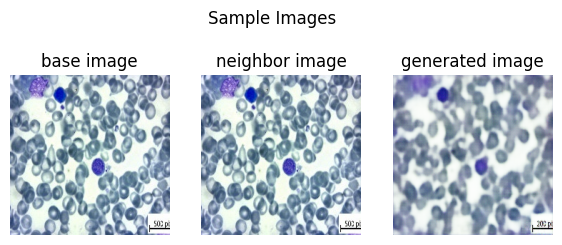

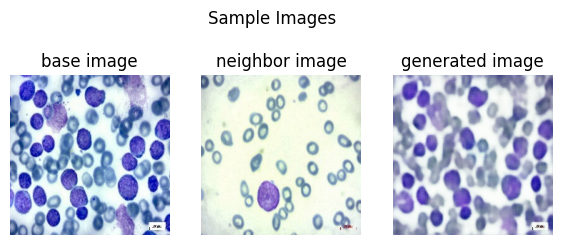

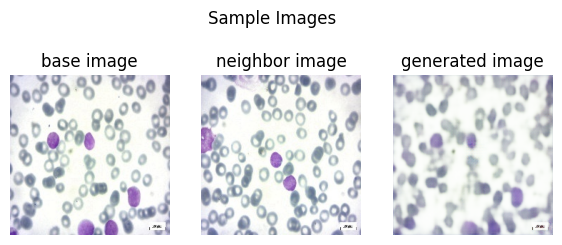

In [ ]:
generated_data = deepsmote.generate_samples(
    limit=300,
    target=788,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    path_encoder="best_encode.pth",
    path_decoder="best_decode.pth"
)

In [ ]:
def save_image_to_drive(data, path):
    classes = os.listdir('/content/drive/MyDrive/SKRIPSI/dataset/original/train')
    images = torch.tensor(data['images'], dtype=torch.uint8).numpy()
    labels = data['class'].numpy()

    for clas in classes:
        os.makedirs(os.path.join(path, clas), exist_ok=True)

    for i in range(len(images)):
        img = cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(path, classes[labels[i]], f"{i}.jpg"), img)

In [ ]:
save_image_to_drive(generated_data, '/content/drive/MyDrive/SKRIPSI/dataset/original/generated')

In [ ]:
def plot_distribution_data(original_labels, generated_labels):
    classes = [ kelas for kelas in os.listdir("/content/drive/MyDrive/SKRIPSI/dataset/original/train") ]
    data_counts = {
        'Original': [
            len(original_labels[original_labels==i]) for i in range(len(classes))
        ],
        'Generated': [
            len(generated_labels[generated_labels==i]) for i in range(len(classes))
        ],
    }
    width = 0.6  # the width of the bars: can also be len(x) sequence

    plt. figure(figsize=(8, 115))

    fig, ax = plt.subplots()
    bottom = np.zeros(4)

    for sex, data_count in data_counts.items():
        p = ax.bar(classes, data_count, width, label=sex, bottom=bottom)
        bottom += data_count

        ax.bar_label(p, label_type='center')

    ax.set_title('Jumlah data setiap kelas')
    plt.ylim(0, 1000)
    ax.legend()

    plt.show()

<Figure size 800x11500 with 0 Axes>

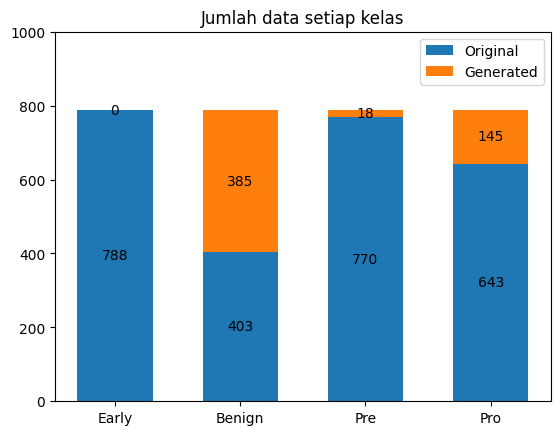

In [ ]:
plot_distribution_data(original_labels=labels, generated_labels=generated_data['class'].numpy())

# Deep SMOTE data training dengan CLAHE

## Load data training

In [ ]:
images, labels = load_data(path="/content/drive/MyDrive/SKRIPSI/dataset/clahe/train")

Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/train


100%|██████████| 643/643 [00:13<00:00, 48.31it/s] 


## Training model

In [ ]:
deepsmote = DeepSMOTE(Encoder(), Decoder())

In [ ]:
deepsmote.fit(
    X={
        'images': torch.tensor(images, dtype=torch.uint8),
        'class': torch.tensor(labels, dtype=torch.uint8)
    },
    epochs=100,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Epoch :1 Train Loss: 0.47258456492865525 Rec Loss: 0.23595071721959998 Penalty_loss: 0.23663385019258218
Menyimpan Model ....
Epoch :2 Train Loss: 0.19114079464364936 Rec Loss: 0.09530544888090205 Penalty_loss: 0.09583534631464216
Menyimpan Model ....
Epoch :3 Train Loss: 0.15873820196699212 Rec Loss: 0.07740278238499607 Penalty_loss: 0.08133542040983836
Menyimpan Model ....
Epoch :4 Train Loss: 0.15097744762897491 Rec Loss: 0.07494008541107178 Penalty_loss: 0.07603736166600827
Menyimpan Model ....
Epoch :5 Train Loss: 0.1460880868964725 Rec Loss: 0.07216945235376004 Penalty_loss: 0.07391863343892274
Menyimpan Model ....
Epoch :6 Train Loss: 0.14378352408055906 Rec Loss: 0.07127759357293446 Penalty_loss: 0.07250593078357202
Menyimpan Model ....
Epoch :7 Train Loss: 0.14221973441265248 Rec Loss: 0.07061743322345945 Penalty_loss: 0.07160230063729817
Menyimpan Model ....
Epoch :8 Train Loss: 0.13999007587079648 Rec Loss: 0.06962229118303016 Penalty_loss: 0.07036778385992404
Menyimpan Mode

## Menampilkan nilai loss setiap epoch

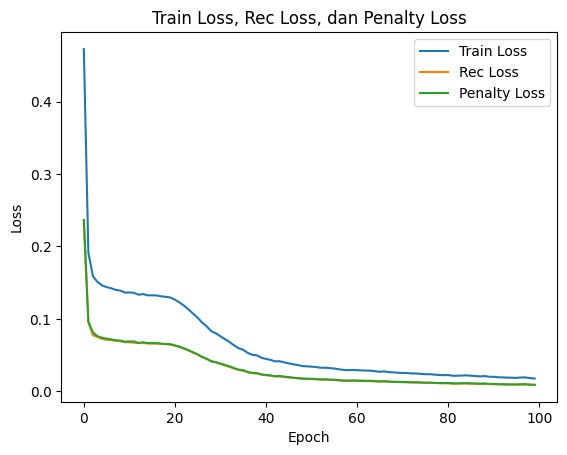

In [ ]:
plot_history(deepsmote.perform)

In [ ]:
!mkdir -p "/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/clahe"
!cp best_decode.pth "/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/clahe/best_decode.pth"
!cp best_encode.pth "/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/clahe/best_encode.pth"
!cp model_perform.pkl "/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/clahe/model_perform.pkl"

## Generate image

0.06526194413503011


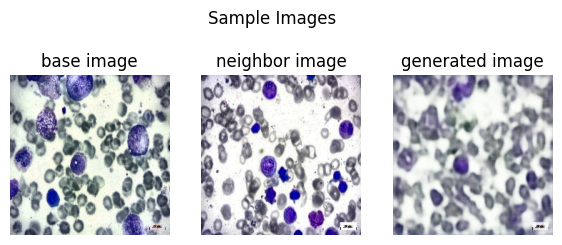

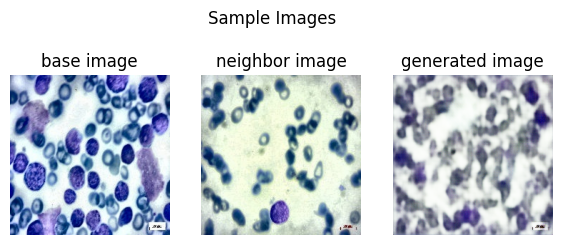

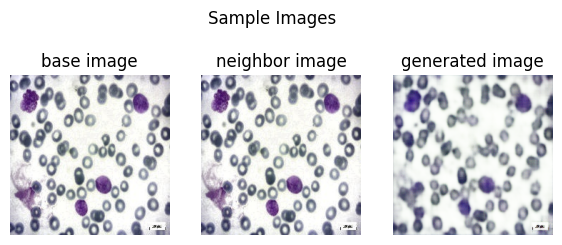

In [ ]:
generated_data = deepsmote.generate_samples(
    limit=300,
    target=788,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    path_encoder="best_encode.pth",
    path_decoder="best_decode.pth"
)

In [ ]:
save_image_to_drive(generated_data, '/content/drive/MyDrive/SKRIPSI/dataset/clahe/generated')

<Figure size 800x11500 with 0 Axes>

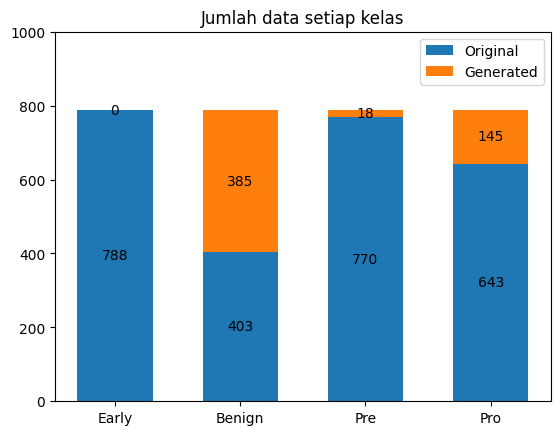

In [ ]:
plot_distribution_data(original_labels=labels, generated_labels=generated_data['class'].numpy())